In [2]:
import pandas as pd
# Load Data
url = 'https://raw.githubusercontent.com/SEAnalytics/datasets/master/storypoint/IEEE%20TSE2018/dataset/mulestudio.csv'
raw_data = pd.read_csv(url)
raw_data.columns
raw_data.head(6)

,issuekey,title,description,storypoint
0,STUDIO-95,Support for request/reply,request/reply http://www.mulesoft.org/documen...,13
1,STUDIO-280,Cannot import a Studio project from Git withou...,Steps to reproduce: 1. Create a simple Mule...,3
2,STUDIO-382,Changes to Java code do not get hot deployed,Java source changes don't get picked up right ...,5
3,STUDIO-459,Unable to add a response when creating a secon...,Unable to add a response when creating a secon...,8
4,STUDIO-618,Namespaces in the XML view are not being remo...,When you add an element and then you remove it...,8
5,STUDIO-781,Would save time to be given the option to crea...,Add a button in the ClassFieldEditor to create...,5


In [3]:
# Check for missing values
raw_data.isnull().sum()


issuekey       0
title          0
description    0
storypoint     0
dtype: int64

In [4]:

# Examine storypoints summary statistics
raw_data.storypoint.describe()

count    732.000000
mean       6.396175
std        5.385687
min        1.000000
25%        3.000000
50%        5.000000
75%        8.000000
max       34.000000
Name: storypoint, dtype: float64

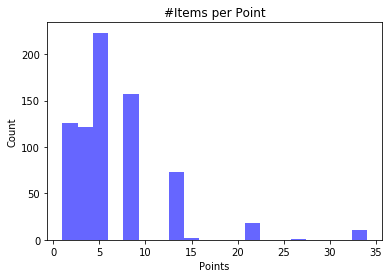

In [5]:
# Visualize number of storypoints distribution
import matplotlib.pyplot as plt
plt.hist(raw_data.storypoint, bins=20, alpha=0.6, color='b')
plt.title("#Items per Point")
plt.xlabel("Points")
plt.ylabel("Count")
plt.show()


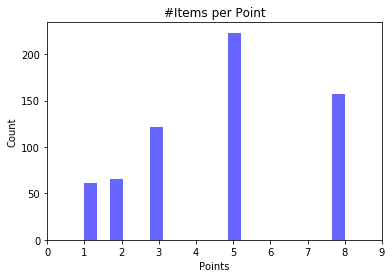

In [6]:
# Zoom in on most common data representing 75% of the dataset
import numpy as np
frequent_data = raw_data.query('storypoint <= 8')
plt.hist(frequent_data.storypoint, bins=20, alpha=0.6, color='b')
plt.title("#Items per Point")
plt.xlabel("Points")
plt.ylabel("Count")
plt.xticks(np.arange(0, 10, 1)) 
plt.show()

In [7]:
# Examine distribution in detail
raw_data.groupby('storypoint').size()

storypoint
1      61
2      65
3     121
5     223
8     157
13     73
15      2
21     18
26      1
34     11
dtype: int64

This shows that 5 the most common number of storypoints assigned to an issue/requirement.

In [9]:
################### Data Preprocessing ###################################

import nltk
from nltk.corpus import stopwords 
nltk.download('punkt')
nltk.download('stopwords')

# Tokenize
raw_data['tokens'] = raw_data['description'].apply(lambda x : nltk.word_tokenize(x))

type(raw_data['description'][0])




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


str

In [10]:
# Convert all words to lower case
raw_data['tokens'] = raw_data['tokens'].apply(lambda x : [w.lower() for w in x])

# Remove punctuation from each word
import string
table = str.maketrans('', '', string.punctuation)
raw_data['tokens'] = raw_data['tokens'].apply(lambda x: [w.translate(table) for w in x])

# Remove tokens that are not alphabetic
raw_data['tokens'] = raw_data['tokens'].apply(lambda x: [w for w in x if w.isalpha()])

# Remove stop words
stop_words = stopwords.words('english')
raw_data['tokens'] = raw_data['tokens'].apply(lambda x: [w for w in x if w not in stop_words])

raw_data['tokens'] = raw_data['tokens'].apply(lambda x: nltk.Text(x))

# Lemmatization
nltk.download('wordnet')
lemmatizer = nltk.WordNetLemmatizer()
raw_data['tokens'] = raw_data['tokens'].apply(lambda x: [lemmatizer.lemmatize(w) for w in x ])

# Stemming
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
raw_data['tokens'] = raw_data['tokens'].apply(lambda x: [porter.stem(w) for w in x ])


raw_data

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,issuekey,title,description,storypoint,tokens
0,STUDIO-95,Support for request/reply,request/reply http://www.mulesoft.org/documen...,13,"[requestrepli, http, wwwmulesoftorgdocumentati..."
1,STUDIO-280,Cannot import a Studio project from Git withou...,Steps to reproduce: 1. Create a simple Mule...,3,"[step, reproduc, creat, simpl, mule, studio, p..."
2,STUDIO-382,Changes to Java code do not get hot deployed,Java source changes don't get picked up right ...,5,"[java, sourc, chang, nt, get, pick, right, aut..."
3,STUDIO-459,Unable to add a response when creating a secon...,Unable to add a response when creating a secon...,8,"[unabl, add, respons, creat, second, flow, ste..."
4,STUDIO-618,Namespaces in the XML view are not being remo...,When you add an element and then you remove it...,8,"[add, element, remov, refer, schema, file, rem..."
...,...,...,...,...,...
727,STUDIO-7360,Add support for changes on connectors editor.xml,"When a Processor has a POJO as a parameter, di...",3,"[processor, pojo, paramet, differ, option, com..."
728,STUDIO-7386,API-GATEWAY Domain creation improvements in St...,When creating a Gateway project Studio automat...,5,"[creat, gateway, project, studio, automat, cre..."
729,STUDIO-7436,Allow studio to discover and instantiate Exten...,Allow studio to discover and instantiate Exten...,8,"[allow, studio, discov, instanti, extensionmodel]"
730,STUDIO-7479,Create mule 4 Studio Runtimes,Discuss were it will be hosted. Verify if the...,3,"[discu, host, verifi, structur, distribut, cha..."


In [11]:
# Vocabulary
vocabulary = set([item for sublist in list(raw_data['tokens']) for item in sublist]) # list of unique words
vocabulary_size = len(vocabulary)
vocabulary_size

2750

In [0]:
# Frequency distribution of words
all_words = [item for sublist in list(raw_data['tokens']) for item in sublist]
len(all_words)
from nltk.probability import FreqDist
fdist = FreqDist(all_words)


In [17]:
list(raw_data['tokens'])[0]

['requestrepli',
 'http',
 'wwwmulesoftorgdocumentationdisplaycurrentroutingmessageprocessor',
 'routingmessageprocessorsrequestrepli',
 'mockup',
 'http',
 'corpwikimulesourcecomdisplaywprequestrepli',
 'requestreplymockup']

In [0]:
# Frequency Distribution of Words Plot
import matplotlib.pyplot as plt
fdist.plot(30,cumulative=False)
plt.show()

In [0]:
# Split data into traning and testing
split_ratio = 0.7
total_number_of_datapoints = len(raw_data.index)
train_number_of_datapoints = int(total_number_of_datapoints * split_ratio)

train_set = raw_data.iloc[:train_number_of_datapoints, :]
test_set = raw_data.iloc[train_number_of_datapoints:, :]

In [0]:
tokens = list(train_set['tokens'])
tokens = [str(i) for i in tokens]
tokens


Count Vectorization (One-Hot-Encoding)

In [0]:
# Create our vectorizer
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(list(train_set['description']))

# Build the classifier
clf = MultinomialNB(alpha=.01)

#  Train the classifier
clf.fit(vectors, train_set['storypoint'].values)

# Get the test vectors
vectors_test = vectorizer.transform(list(test_set['description']))

# Predict and score the vectors
pred = clf.predict(vectors_test)
acc_score = metrics.accuracy_score( test_set['storypoint'].values, pred)
f1_score = metrics.f1_score( test_set['storypoint'].values, pred, average='macro')

print('Total accuracy classification score: {}'.format(acc_score))
print('Total F1 classification score: {}'.format(f1_score))


Total accuracy classification score: 0.2318181818181818
Total F1 classification score: 0.08581564542544987
